In [1]:
import os
import glob
import argparse
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [2]:
font_path = './HelveticaNeue.ttc'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['YourFontName'] + plt.rcParams['font.serif']
plt.rcParams["font.weight"] = "normal"
matplotlib.font_manager.fontManager.addfont(font_path)

In [3]:
def filter_outliers(y, x, num, threshold):
    outliers = [i for i in range(num, len(y) - num) if np.abs(y[i] - np.mean(y[i-num:i+num])) > threshold]
    return np.delete(x, outliers), np.delete(y, outliers)

def smooth(x, y, window_size):
    window = np.ones(window_size)/window_size
    return x[window_size-1:], np.convolve(y, window, mode='valid')

def mean_window(x, y, window_size):
    return np.mean(x.reshape(-1, window_size), axis=1), np.mean(y.reshape(-1, window_size), axis=1)

def plot(x, y, label, ylim=None):
    plt.plot(x, y, label=label)
    if ylim:
        plt.ylim(ylim)
    plt.xlabel('Tokens')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

def get_tokens_df(target_value,loss_df):
    diff = np.abs(loss_df['Value'] - target_value) 
    index = diff.idxmin() 
    return loss_df['Step'][index]

def get_tokens(target_value,x,y):
    diff = np.abs(y - target_value)
    index = np.argmin(diff)
    return x[index] 

In [4]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def func(l, a, b, c):
    return a*np.log(l) + b * l + c

def plotBatchSizeLoss(min_values, LR):
    plt.figure()
    y_loss = np.array([k for k in min_values.keys() ])
    x_batch_size = np.array([value[0]*8192 for k,value in min_values.items()])

    coeffs = np.polyfit(np.log(x_batch_size), y_loss, deg=1)
    print('k,b:', coeffs)

    f = np.poly1d(coeffs)
    plt.plot(np.log(x_batch_size),f(np.log(x_batch_size)), '-b', label='Fitted line')

    plt.scatter(np.log(x_batch_size), y_loss, color='red')
    plt.plot(np.log(x_batch_size), y_loss, color='red', label='Experimental Results')
    plt.legend()


    plt.xlabel('Batch Size')
    plt.ylabel('Loss')
    plt.rc('xtick', labelsize=7)
    plt.rc('ytick', labelsize=7)
    plt.xscale('log')
    plt.show()
    
def plotBatchSizeTokens(path_save, filename_prefix,model_size, color_upper_bound, color_lower_bound, SMOOTH,threshold, batch_size_list, lr_list, lr_min_values):
    for LR in lr_list:
        loss_L = []
        for i in range(color_upper_bound,color_lower_bound, -1):
            loss_L.append(i/100)

        df = pd.DataFrame({'loss': loss_L})

        df_L = []
        for bs in batch_size:
            csv_name = path_save + 'llama_' + model_size + filename_prefix%(LR,bs,LR)
            
            loss_df = pd.read_csv(csv_name + '.csv')

            # smooth 操作
            x, y = loss_df['Step'].values, loss_df['Value'].values
            x, y = filter_outliers(y, x, SMOOTH, threshold)
            x, y = smooth(x, y, SMOOTH) 
            df_L.append(loss_df)

            bs_L = []
            for loss in loss_L:
                t = get_tokens(loss,x,y)
                bs_L.append(t)
            df[bs] = bs_L

        for col in df.columns:
            if col == 256 or col == 128:
                df.loc[df[col].diff() <= 0, col] = np.nan

        flag = 0
        min_values = {} 
        
        cmap = plt.get_cmap('plasma_r')
        norm = plt.Normalize(COLOR_LOWER_BOUND/100, COLOR_UPPER_BOUND/100)

        fig, ax = plt.subplots()
        control_num = int(df.shape[0]/2)

        for index, row in df.iterrows(): 
            min_value = min(row.values[1:])
            min_column = df.columns[row.values[1:].tolist().index(min_value)+1]

            tmp = row.values[0] 
            x = df.columns[1:].values.astype(int)
            y = row.values[1:].astype(float)
            plt.semilogy(x, y, linestyle='dashed', color=cmap(norm(tmp)), label=f'index={tmp}')
            plt.scatter(x, y, color=cmap(norm(tmp)), s = 5)

            mask = ~np.isnan(y)
            x = x[mask]
            y = y[mask]

            z = np.polyfit(np.log(x), y, deg=2)
            p = np.poly1d(z)
            pseudo_x = range(10,2816,1)
            pseudo_y = p(np.log(pseudo_x))

            plt.semilogy(pseudo_x, pseudo_y, color=cmap(norm(tmp)), label=f'Fitted Curve for index={tmp}')  # 绘制拟合后的曲线
            min_x = pseudo_x[np.argmin(pseudo_y)]
            min_y = min(pseudo_y) 
            min_values[tmp] = (min_x, min_y)

        plt.title('Model Size ' + str(model_size)+', Learning Rate '+ LR.split('_')[0])

        x = np.array([value[0] for value in min_values.values()])
        y = np.array([value[1] for value in min_values.values()])

        coeffs = np.polyfit(np.log(x), y, deg=1)
        print(coeffs)
        ax = plt.gca() 
        ax.tick_params(axis='both', labelsize=10)

        f = np.poly1d(coeffs)
        plt.plot(x,y, '-r', label='Min Values')

        
        ax = plt.gca() 

        plt.yticks([4e9, 5e9, 6e9, 1e10, 2e10], fontsize=10)
        plt.xticks([0, 128, 256, 512, 1024], fontsize=10)
        plt.xlabel('Batch Size')
        plt.ylabel('Token Processed')
        plt.ylim(4e9, 2e10)
        plt.xlim(0, 512)

        cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
        cbar.set_label('Training Loss')
        plt.savefig('heatmap' + '_' + str(model_size) + '_' + LR + '.pdf', bbox_inches='tight')  # 显示图

        plotBatchSizeLoss(min_values, LR)
        lr_min_values[LR].update(min_values)
    return lr_min_values
    

[ 5.03155512e+10 -2.58770338e+11]
k,b: [-1.52102054 24.75448627]


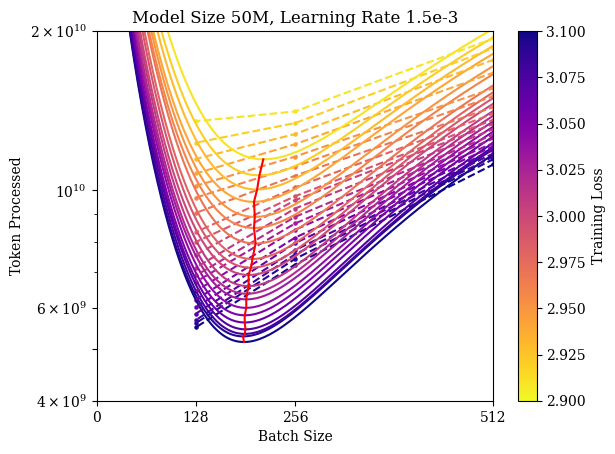

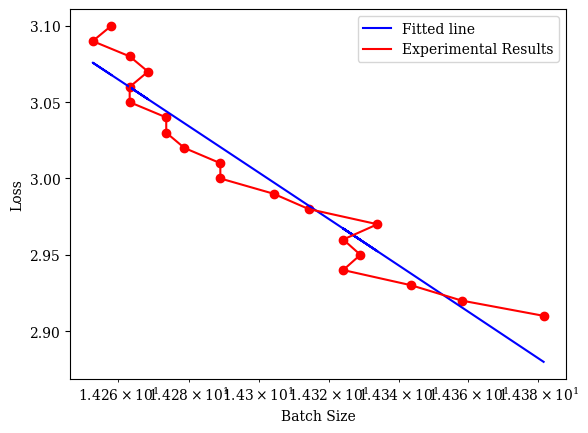

In [5]:
COLOR_UPPER_BOUND = 310
COLOR_LOWER_BOUND = 290
SMOOTH = 300
threshold = 0.01
batch_size = [2816,2048,1024,512,256,128]
LR_L_small = ['1.5e-3_1.5e-4']
model_size = '50M'
lr_min_values_small = {}
for lr in LR_L_small:
    lr_min_values_small[lr] = {}
lr_min_values_small = plotBatchSizeTokens(path_save, filename_prefix,model_size, COLOR_UPPER_BOUND, COLOR_LOWER_BOUND, SMOOTH, threshold,batch_size, LR_L_small, lr_min_values_small)  

[ 2.68740317e+10 -1.35663913e+11]
k,b: [-1.1948087 19.7444866]


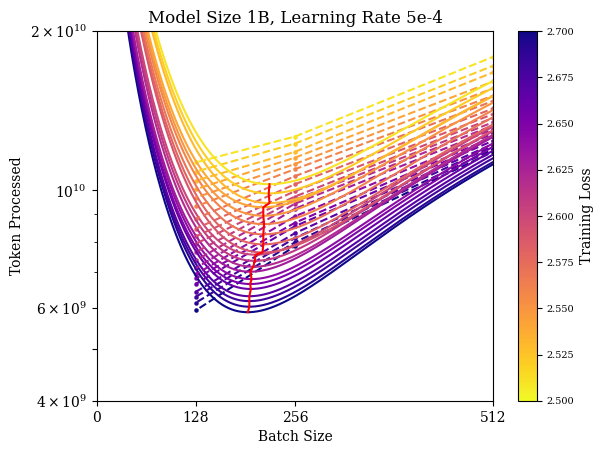

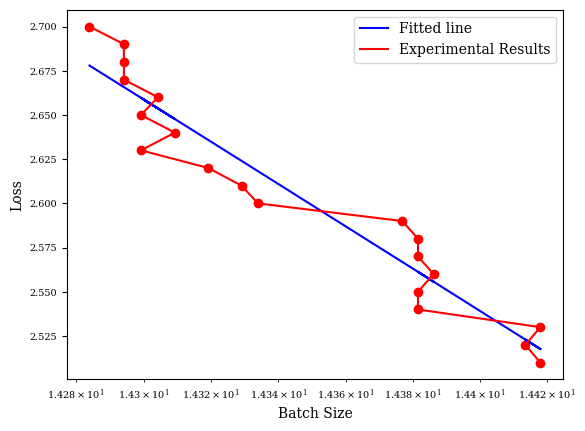

[ 3.50788558e+10 -1.84977682e+11]
k,b: [-1.80671468 28.77206914]


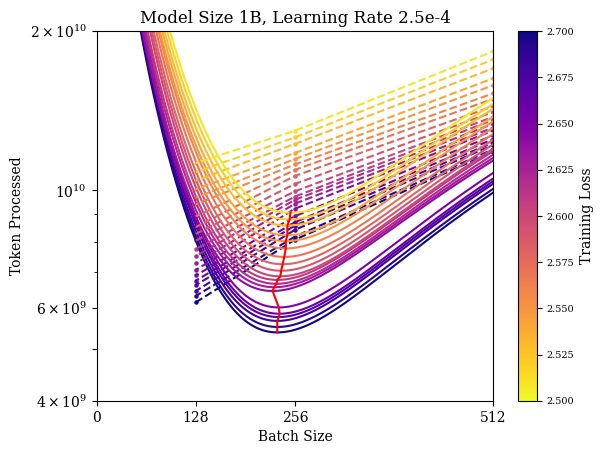

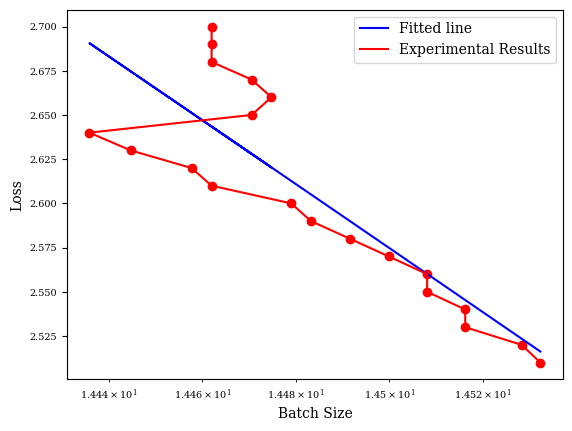

In [6]:
COLOR_UPPER_BOUND = 270
COLOR_LOWER_BOUND = 250
SMOOTH = 300
threshold = 0.01
batch_size = [2816,2048,1024,512,256,128]
LR_L_pred = ['5e-4_5e-5', '2.5e-4_2.5e-5']
model_size = '1B'
lr_min_values_pred = {}
for lr in LR_L_pred:
    lr_min_values_pred[lr] = {}
lr_min_values_large = plotBatchSizeTokens(path_save, filename_prefix, model_size, COLOR_UPPER_BOUND, COLOR_LOWER_BOUND, SMOOTH, threshold, batch_size, LR_L_pred, lr_min_values_pred) 


[ 5.41956461e+10 -2.87141300e+11]
k,b: [-1.73281533 27.66911124]


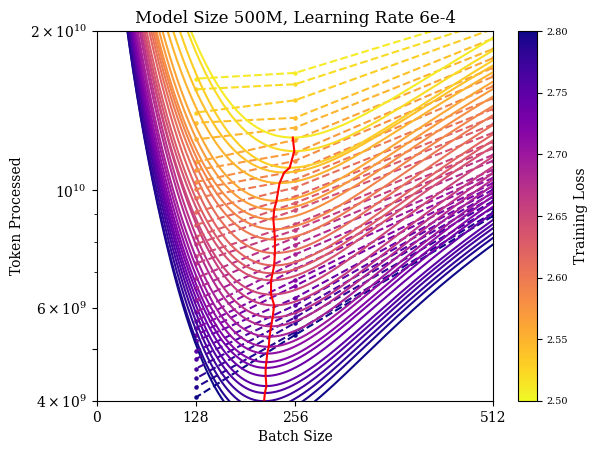

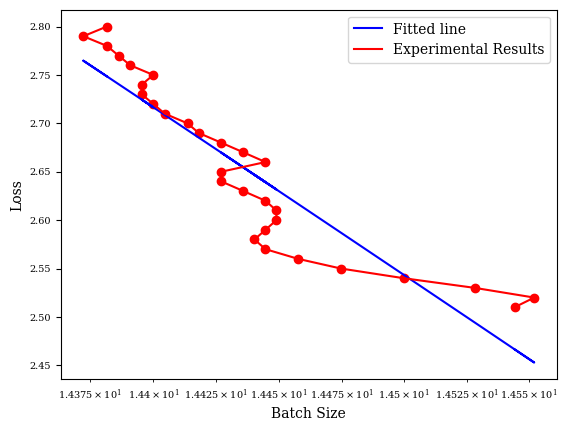

In [7]:
COLOR_UPPER_BOUND = 280
COLOR_LOWER_BOUND = 250
SMOOTH = 100
threshold = 0.01
batch_size = [2816,2048,1024,512,256,128]#
LR_L_large = ['6e-4_6e-5']
model_size = '500M'
lr_min_values_large = {}
for lr in LR_L_large:
    lr_min_values_large[lr] = {}
lr_min_values_large = plotBatchSizeTokens(path_save, filename_prefix, model_size, COLOR_UPPER_BOUND, COLOR_LOWER_BOUND, SMOOTH, threshold, batch_size, LR_L_large, lr_min_values_large)

[ 4.54630206e+10 -2.35529070e+11]
k,b: [-1.89096705 30.01147151]


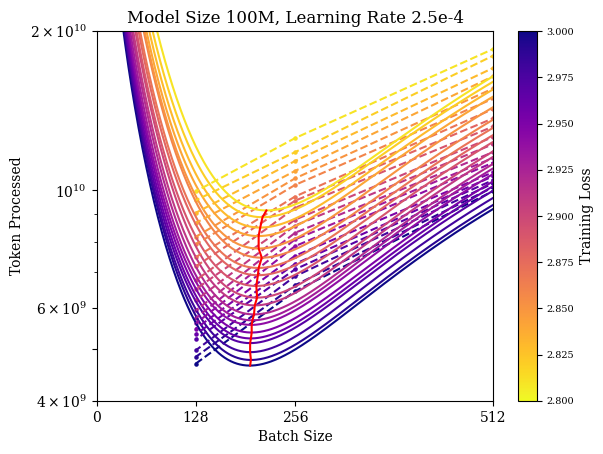

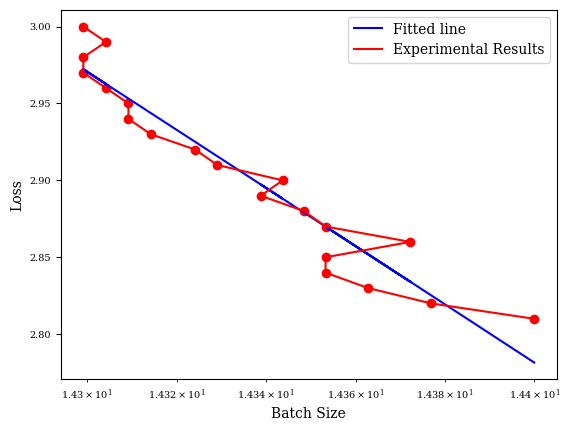

In [8]:
path_save =
filename_prefix = 
COLOR_UPPER_BOUND = 300
COLOR_LOWER_BOUND = 280
SMOOTH =100
threshold = 0.01
batch_size = [2816,2048,1024,512,256,128]#
LR_L_mid = ['2.5e-4_2.5e-5']
model_size = '100M'
lr_min_values_mid = {}
for lr in LR_L_mid:
    lr_min_values_mid[lr] = {}
lr_min_values_mid = plotBatchSizeTokens(path_save, filename_prefix,model_size, COLOR_UPPER_BOUND, COLOR_LOWER_BOUND, SMOOTH, threshold,batch_size, LR_L_mid, lr_min_values_mid)  

In [9]:
def filter_anomaly(x, y, y_pred, threshold):
    cleaned_x, cleaned_y = [], []
    for i in range(len(x)):
        if abs(y[i] - y_pred[i]) < threshold:
            cleaned_x.append(x[i])
            cleaned_y.append(y[i])
    return cleaned_x, cleaned_y

k,b: [-0.50718957  8.35253493]
k,b: [-0.65182607 10.40997653]
k,b: [-0.65551906 10.43867919]
k,b: [-0.82175468 12.84400275]


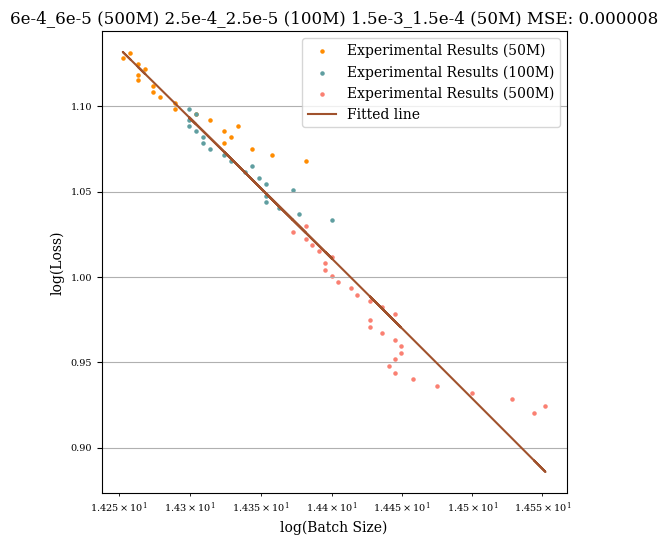

7.645533316669747e-06


In [10]:
anomaly_threshold = 0.2
mse_score_list2 = []
for lr_large in ['6e-4_6e-5']:
    for lr_mid in ['2.5e-4_2.5e-5']:
        for lr_small in ['1.5e-3_1.5e-4']:
            dataset_x = []
            dataset_y = []
            # plot 50m model
            plt.figure(figsize=(6,6))
            lr_min_value = lr_min_values_small[lr_small]
            y_loss = np.array([k for k in lr_min_value.keys() ])
            x_batch_size = np.array([value[0]*8192 for k,value in lr_min_value.items()])
            
            coeffs = np.polyfit(np.log(x_batch_size), np.log(y_loss), deg=1)
            print('k,b:', coeffs)
            f = np.poly1d(coeffs)
            cleaned_x, cleaned_y = filter_anomaly(np.log(x_batch_size), np.exp(np.log(y_loss)), np.exp(f(np.log(x_batch_size))), anomaly_threshold)
            cleaned_y = np.log(cleaned_y)
            dataset_x.extend(cleaned_x)
            dataset_y.extend(cleaned_y)
            plt.scatter(cleaned_x, cleaned_y, s = 5, color='darkorange',  label='Experimental Results (50M)')

            # plot 100m model
            lr_min_value = lr_min_values_mid[lr_mid]
            y_loss = np.array([k for k in lr_min_value.keys() ])
            x_batch_size = np.array([value[0]*8192 for k,value in lr_min_value.items()])
            coeffs = np.polyfit(np.log(x_batch_size), np.log(y_loss), deg=1)
            print('k,b:', coeffs)
            f = np.poly1d(coeffs)
            cleaned_x, cleaned_y = filter_anomaly(np.log(x_batch_size), np.exp(np.log(y_loss)), np.exp(f(np.log(x_batch_size))), anomaly_threshold)
            cleaned_y = np.log(cleaned_y)
            dataset_x.extend(cleaned_x)
            dataset_y.extend(cleaned_y)
            plt.scatter(cleaned_x, cleaned_y, s = 5, color='cadetblue', label='Experimental Results (100M)')

            # plot 500 m model
            lr_min_value = lr_min_values_large[lr_large]
            y_loss = np.array([k for k in lr_min_value.keys() ])
            x_batch_size = np.array([value[0]*8192 for k,value in lr_min_value.items()])
            coeffs = np.polyfit(np.log(x_batch_size), np.log(y_loss), deg=1)
            print('k,b:', coeffs)
            f = np.poly1d(coeffs)
            cleaned_x, cleaned_y = filter_anomaly(np.log(x_batch_size), np.exp(np.log(y_loss)), np.exp(f(np.log(x_batch_size))), anomaly_threshold)
            cleaned_y = np.log(cleaned_y)
            dataset_x.extend(cleaned_x)
            dataset_y.extend(cleaned_y)
            plt.scatter(cleaned_x, cleaned_y, s = 5, color='salmon',label='Experimental Results (500M)')
            
            
            coeffs = np.polyfit(dataset_x, dataset_y, deg=1)
            print('k,b:', coeffs)
            f = np.poly1d(coeffs)
            plt.plot(dataset_x,f(dataset_x), 'sienna', label='Fitted line')
            mse_score = (np.square(np.exp(dataset_y) - np.exp(f(dataset_x)))**2).mean()
            mse_score_list2.append(mse_score)
            
            plt.legend()
            plt.grid()
            plt.xlabel('log(Batch Size)')
            plt.ylabel('log(Loss)')
            plt.title(lr_large + ' (500M) ' + lr_mid+ ' (100M) ' + lr_small+ ' (50M) MSE: {:.6f}'.format(mse_score) )
            plt.rc('xtick', labelsize=7)
            plt.rc('ytick', labelsize=7)
            plt.xscale('log')
            plt.show()
print(np.mean(mse_score_list2))

In [11]:
lr_large = '6e-4_6e-5'
lr_mid = '2.5e-4_2.5e-5'
lr_small = '1.5e-3_1.5e-4'
critical_batchsize_loss_file = 'critical_batchsize_loss_v2.csv'
model_size_list = []
batch_size_list = []
loss_list = []

import pandas as pd
df = pd.DataFrame()

lr_min_value = lr_min_values_small[lr_small]
y_loss = np.array([k for k in lr_min_value.keys()])
x_batch_size = np.array([value[0]*8192 for k,value in lr_min_value.items()])
for i in range(len(x_batch_size)):
    model_size_list.append('50M')
    batch_size_list.append(x_batch_size[i])
    loss_list.append(y_loss[i])
    
lr_min_value = lr_min_values_mid[lr_mid]
y_loss = np.array([k for k in lr_min_value.keys()])
x_batch_size = np.array([value[0]*8192 for k,value in lr_min_value.items()])
for i in range(len(x_batch_size)):
    model_size_list.append('100M')
    batch_size_list.append(x_batch_size[i])
    loss_list.append(y_loss[i])
    
lr_min_value = lr_min_values_large[lr_large]
y_loss = np.array([k for k in lr_min_value.keys()])
x_batch_size = np.array([value[0]*8192 for k,value in lr_min_value.items()])
for i in range(len(x_batch_size)):
    model_size_list.append('500M')
    batch_size_list.append(x_batch_size[i])
    loss_list.append(y_loss[i])
    
df = pd.DataFrame({'model_size': model_size_list, 'batch_size': batch_size_list, 'loss':loss_list})
df.to_csv(critical_batchsize_loss_file, index=False)

In [12]:
df = pd.read_csv(critical_batchsize_loss_file)

In [13]:
LR_L_pred = ['5e-4_5e-5', '2.5e-4_2.5e-5']
for lr_pred in LR_L_pred:
    lr_min_value = lr_min_values_pred[lr_pred]
    y_loss = np.array([k for k in lr_min_value.keys()])
    x_batch_size = np.array([value[0]*8192 for k,value in lr_min_value.items()])
    df = pd.DataFrame({'model_size': '1B', 'batch_size': x_batch_size, 'loss':y_loss})
    df.to_csv('pred_batchsize_loss_'+lr_pred+'.csv', index=False)

[1597440 1613824 1613824 1613824 1630208 1622016 1638400 1622016 1654784
 1671168 1679360 1753088 1761280 1761280 1769472 1761280 1761280 1826816
 1818624 1826816] [2.7  2.69 2.68 2.67 2.66 2.65 2.64 2.63 2.62 2.61 2.6  2.59 2.58 2.57
 2.56 2.55 2.54 2.53 2.52 2.51]
[1908736 1908736 1908736 1925120 1933312 1925120 1859584 1875968 1900544
 1908736 1941504 1949696 1966080 1982464 1998848 1998848 2015232 2015232
 2039808 2048000] [2.7  2.69 2.68 2.67 2.66 2.65 2.64 2.63 2.62 2.61 2.6  2.59 2.58 2.57
 2.56 2.55 2.54 2.53 2.52 2.51]


In [14]:
threshold = 0.01 * 0.01
batch_size = [2816,2048,1024,512,256,128]

def samplePoints(lr_loss_bs_tokens_dict):
    sampled_bs_lr_loss = {}
    for _lr in lr_loss_bs_tokens_dict.keys():
        for _loss in lr_loss_bs_tokens_dict[_lr].keys():
            _bs, _tn = lr_loss_bs_tokens_dict[_lr][_loss]
            sampled_bs_lr_loss.update({_loss: (_bs, _lr, _tn)})
    return sampled_bs_lr_loss

In [15]:
sampled_bs_lr_loss_1B = samplePoints(lr_min_values_pred)
sampled_bs_lr_loss_500M = samplePoints(lr_min_values_large)
sampled_bs_lr_loss_100M = samplePoints(lr_min_values_mid)
sampled_bs_lr_loss_50M = samplePoints(lr_min_values_small)

In [16]:
sampled_points_flop_bs = []
sampled_points_N_bs = []
sampled_points_D_bs = []
for k,v in sampled_bs_lr_loss_1B.items():
    sampled_points_flop_bs.append([v[2] * 131.24 * (10 ** 12), v[0]])
    sampled_points_N_bs.append([1 * (10 ** 9), v[0]])
    sampled_points_D_bs.append([v[2], v[0]])
    
for k,v in sampled_bs_lr_loss_100M.items():
    sampled_points_flop_bs.append([v[2] * 30.17 * (10 ** 12), v[0]])
    sampled_points_N_bs.append([100 * (10 ** 6), v[0]])
    sampled_points_D_bs.append([v[2], v[0]])
    
for k,v in sampled_bs_lr_loss_500M.items():
    sampled_points_flop_bs.append([v[2] * 80.71 * (10 ** 12), v[0]])
    sampled_points_N_bs.append([500 * (10 ** 6), v[0]])
    sampled_points_D_bs.append([v[2], v[0]])
    
for k,v in sampled_bs_lr_loss_50M.items():
    sampled_points_flop_bs.append([v[2] * 16.91 * (10 ** 12), v[0]])
    sampled_points_N_bs.append([50 * (10 ** 6), v[0]])
    sampled_points_D_bs.append([v[2], v[0]])

k,b: [0.09695572 0.12939187]


Text(0.5, 1.0, 'Optimal Batch Size vs FLOPs')

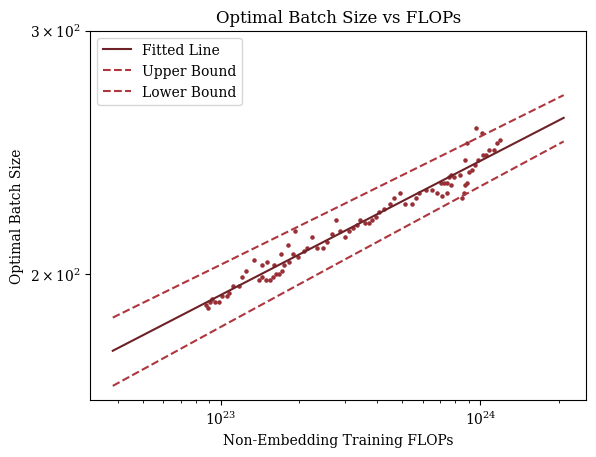

In [17]:
pseudo_x = np.arange(52, 57, 1)
coeffs = np.polyfit(np.log(np.array(sampled_points_flop_bs)[:,0]), np.log(np.array(sampled_points_flop_bs)[:,1]), deg=1)
print('k,b:', coeffs)
f = np.poly1d(coeffs)
plt.plot(np.exp(pseudo_x), np.exp(f(pseudo_x)), color = '#6d2227', label='Fitted Line')
plt.plot(np.exp(pseudo_x), np.exp(f(pseudo_x)) - 10,  linestyle='--', color='#ae363e', label='Upper Bound')
plt.plot(np.exp(pseudo_x), np.exp(f(pseudo_x)) + 10, linestyle='--', color='#ae363e',  label='Lower Bound')

plt.scatter(np.array(sampled_points_flop_bs)[:,0],np.array(sampled_points_flop_bs)[:,1],s=5,color='#983036')
plt.yscale('log')
plt.xscale('log')

ax = plt.gca() 
plt.yticks([200, 300], fontsize=10)
ax.tick_params(axis='both', labelsize=10)

plt.legend()
plt.xlabel('Non-Embedding Training FLOPs')
plt.ylabel('Optimal Batch Size')
plt.title('Optimal Batch Size vs FLOPs')
# plt.savefig('optimal_bs_flops.pdf', bbox_inches='tight')

In [18]:
sampled_points_bs_loss = []
sampled_points_bs_loss_1B = []
sampled_points_bs_loss_100M = []
sampled_points_bs_loss_500M = []
sampled_points_bs_loss_50M = []
for k,v in sampled_bs_lr_loss_1B.items():
    sampled_points_bs_loss.append([v[0], k, v[2]/(10 ** 9)])
    sampled_points_bs_loss_1B.append([v[0], k, v[2]/(10 ** 9)])
for k,v in sampled_bs_lr_loss_100M.items():
    sampled_points_bs_loss.append([v[0], k, v[2]/(100 * 10 ** 6)])
    sampled_points_bs_loss_100M.append([v[0], k, v[2]/(100 * 10 ** 6)])
for k,v in sampled_bs_lr_loss_500M.items():
    sampled_points_bs_loss.append([v[0], k,  v[2]/(500 * 10 ** 6)])
    sampled_points_bs_loss_500M.append([v[0], k,  v[2]/(500 * 10 ** 6)])
for k,v in sampled_bs_lr_loss_50M.items():
    sampled_points_bs_loss.append([v[0], k,  v[2]/(50 * 10 ** 6)])
    sampled_points_bs_loss_50M.append([v[0], k,  v[2]/(50 * 10 ** 6)])

k,b: [0.09695572 0.12939187]


Text(0.5, 1.0, 'Optimal Batch Size vs FLOPs (across OTR)')

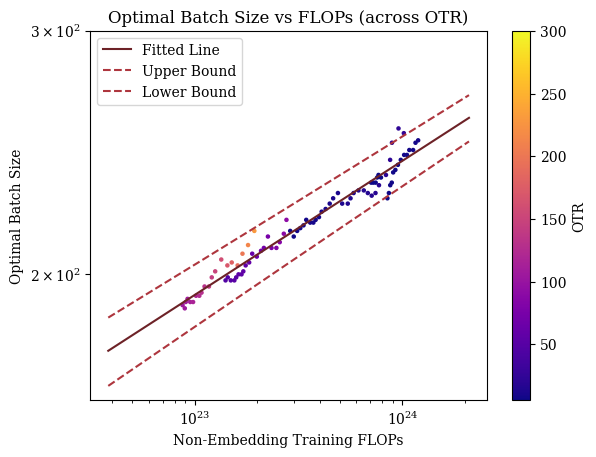

In [19]:

c = np.array(sampled_points_bs_loss)[:,2]
fig, ax = plt.subplots()
cmap = plt.get_cmap('plasma')
norm = plt.Normalize(min(c), 300)

pseudo_x = np.arange(52, 57, 1)
coeffs = np.polyfit(np.log(np.array(sampled_points_flop_bs)[:,0]), np.log(np.array(sampled_points_flop_bs)[:,1]), deg=1)
print('k,b:', coeffs)
f = np.poly1d(coeffs)
plt.plot(np.exp(pseudo_x), np.exp(f(pseudo_x)), color = '#6d2227', label='Fitted Line')
plt.plot(np.exp(pseudo_x), np.exp(f(pseudo_x)) - 10,  linestyle='--', color='#ae363e', label='Upper Bound')
plt.plot(np.exp(pseudo_x), np.exp(f(pseudo_x)) + 10, linestyle='--', color='#ae363e',  label='Lower Bound')
plt.legend()
plt.scatter(np.array(sampled_points_flop_bs)[:,0],np.array(sampled_points_flop_bs)[:,1],s=5, color = cmap(norm(c)))
plt.yscale('log')
plt.xscale('log')

ax = plt.gca() 
plt.yticks([200, 300], fontsize=10)
ax.tick_params(axis='both', labelsize=10)

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('OTR', fontsize = 10)
cbar.ax.tick_params(labelsize=10) 

plt.xlabel('Non-Embedding Training FLOPs')
plt.ylabel('Optimal Batch Size')
plt.title('Optimal Batch Size vs FLOPs (across OTR)')
# plt.savefig('optimal_bs_flops_otr.pdf', bbox_inches='tight')


k,b: [0.06154892 4.19372897]


Text(0.5, 1.0, 'Optimal Batch Size vs Model Size')

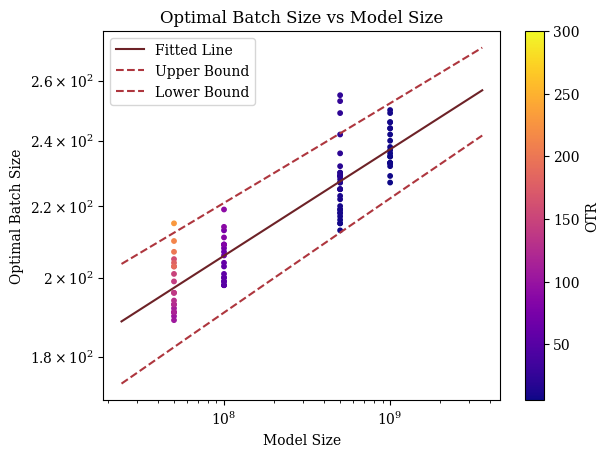

In [20]:
x = np.array(sampled_points_N_bs)[:,0]
y = np.array(sampled_points_N_bs)[:,1]

fig, ax = plt.subplots()
pseudo_x = np.arange(17, 23, 1)
coeffs = np.polyfit(np.log(x), np.log(y), deg=1)
print('k,b:', coeffs)
f = np.poly1d(coeffs)
plt.plot(np.exp(pseudo_x), np.exp(f(pseudo_x)), color= '#6d2227', label='Fitted Line')
plt.plot(np.exp(pseudo_x), np.exp(f(pseudo_x)) - 15,  linestyle='--', color='#ae363e', label='Upper Bound')
plt.plot(np.exp(pseudo_x), np.exp(f(pseudo_x)) + 15, linestyle='--', color='#ae363e',  label='Lower Bound')

plt.yscale('log')
plt.xscale('log')

ax = plt.gca() 
plt.yticks([160, 180, 200, 220, 240, 260], fontsize=10)
ax.tick_params(axis='both', labelsize=10)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('OTR', fontsize = 10)
cbar.ax.tick_params(labelsize=10) 

plt.scatter(x, y, s=10, color = cmap(norm(c)))
plt.legend()
plt.xlabel('Model Size')
plt.ylabel('Optimal Batch Size')
plt.title('Optimal Batch Size vs Model Size')
# plt.savefig('optimal_bs_model_size_otr.pdf', bbox_inches='tight')

k,b: [0.06154892 4.19372897]


Text(0.5, 1.0, 'Optimal Batch Size vs Model Size')

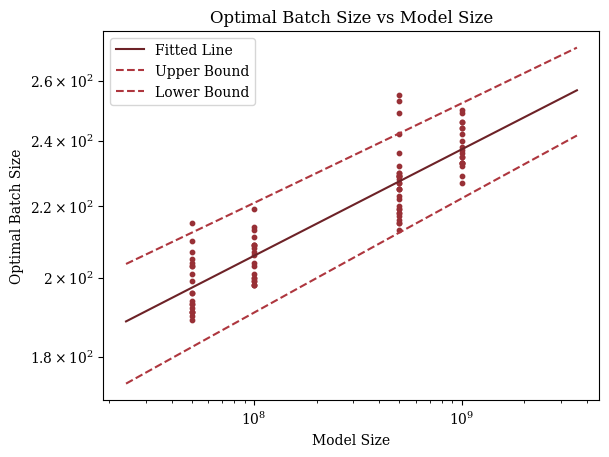

In [21]:
x = np.array(sampled_points_N_bs)[:,0]
y = np.array(sampled_points_N_bs)[:,1]
c = np.array(sampled_points_bs_loss)[:,2]
fig, ax = plt.subplots()
cmap = plt.get_cmap('plasma')
norm = plt.Normalize(min(c), 300)

pseudo_x = np.arange(17, 23, 1)
coeffs = np.polyfit(np.log(x), np.log(y), deg=1)
print('k,b:', coeffs)
f = np.poly1d(coeffs)
plt.plot(np.exp(pseudo_x), np.exp(f(pseudo_x)), color= '#6d2227', label='Fitted Line')
plt.plot(np.exp(pseudo_x), np.exp(f(pseudo_x)) - 15,  linestyle='--', color='#ae363e', label='Upper Bound')
plt.plot(np.exp(pseudo_x), np.exp(f(pseudo_x)) + 15, linestyle='--', color='#ae363e',  label='Lower Bound')

plt.yscale('log')
plt.xscale('log')

ax = plt.gca() 
plt.yticks([160, 180, 200, 220, 240, 260], fontsize=10)
ax.tick_params(axis='both', labelsize=10)
plt.scatter(x, y,color = '#983036',s=10)
plt.legend()
plt.xlabel('Model Size')
plt.ylabel('Optimal Batch Size')
plt.title('Optimal Batch Size vs Model Size')
# plt.savefig('optimal_bs_model_size.pdf', bbox_inches='tight')

k,b: [-0.77275173  5.17878224]


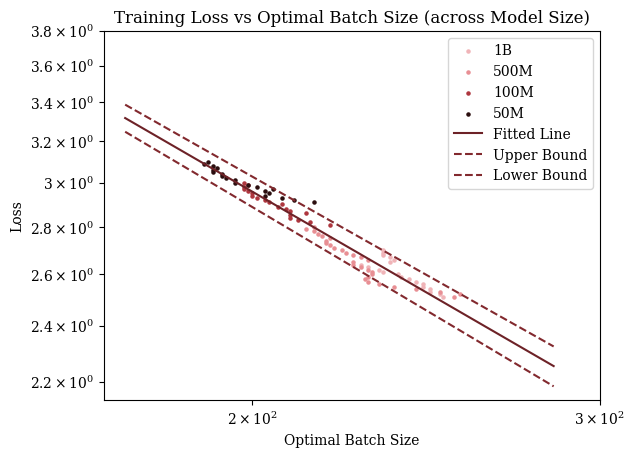

In [22]:
x = np.array(sampled_points_bs_loss)[:,0]
y = np.array(sampled_points_bs_loss)[:,1]

fig, ax = plt.subplots()

plt.scatter(np.array(sampled_points_bs_loss_1B)[:,0], np.array(sampled_points_bs_loss_1B)[:,1], s=5, color = '#f0b4b8', label = '1B')
plt.scatter(np.array(sampled_points_bs_loss_500M)[:,0], np.array(sampled_points_bs_loss_500M)[:,1], s=5, color = '#e88f94', label = '500M')
plt.scatter(np.array(sampled_points_bs_loss_100M)[:,0], np.array(sampled_points_bs_loss_100M)[:,1], s=5, color = '#ae363e', label = '100M')
plt.scatter(np.array(sampled_points_bs_loss_50M)[:,0], np.array(sampled_points_bs_loss_50M)[:,1], s=5, color = '#2b0e0f', label = '50M')

pseudo_x = np.arange(5.15, 5.7, 0.1)
coeffs = np.polyfit(np.log(x), np.log(y), deg=1)
print('k,b:', coeffs)
f = np.poly1d(coeffs)
plt.plot(np.exp(pseudo_x), np.exp(f(pseudo_x)), color = '#6d2227', label='Fitted Line')
plt.plot(np.exp(pseudo_x), np.exp(f(pseudo_x)) + 0.07,  linestyle='--', color='#82292e', label='Upper Bound')
plt.plot(np.exp(pseudo_x), np.exp(f(pseudo_x)) - 0.07, linestyle='--', color='#82292e',  label='Lower Bound')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Optimal Batch Size')
plt.ylabel('Loss')

ax = plt.gca() 

plt.yticks([2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8], fontsize=10)
plt.xticks([200, 300], fontsize=10)
plt.title('Training Loss vs Optimal Batch Size (across Model Size)')
ax.tick_params(axis='both', labelsize=10)
plt.savefig('optimal_bs_ms_loss.pdf', bbox_inches='tight')

k,b: [-0.77275173  5.17878224]


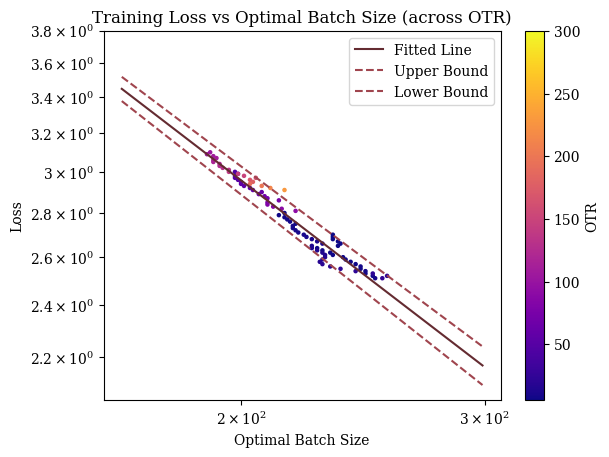

In [23]:
x = np.array(sampled_points_bs_loss)[:,0]
y = np.array(sampled_points_bs_loss)[:,1]
c = np.array(sampled_points_bs_loss)[:,2]

cmap = plt.get_cmap('plasma')
norm = plt.Normalize(min(c), 300)
fig, ax = plt.subplots()
plt.scatter(x, y, s=5, color = cmap(norm(c)))

pseudo_x = np.arange(5.1, 5.7, 0.1)
coeffs = np.polyfit(np.log(x), np.log(y), deg=1)
print('k,b:', coeffs)
f = np.poly1d(coeffs)
plt.plot(np.exp(pseudo_x), np.exp(f(pseudo_x)), color = '#642b31', label='Fitted Line')
plt.plot(np.exp(pseudo_x), np.exp(f(pseudo_x)) + 0.07,  linestyle='--', color='#a0454e', label='Upper Bound')
plt.plot(np.exp(pseudo_x), np.exp(f(pseudo_x)) - 0.07, linestyle='--', color='#a0454e',  label='Lower Bound')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Optimal Batch Size')
plt.ylabel('Loss')

ax = plt.gca() 

plt.yticks([2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8], fontsize=10)
plt.xticks([200, 300], fontsize=10)
ax.tick_params(axis='both', labelsize=10)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('OTR', fontsize = 10)
cbar.ax.tick_params(labelsize=10) 

plt.title('Training Loss vs Optimal Batch Size (across OTR)')
plt.savefig('optimal_bs_otr_loss.pdf', bbox_inches='tight')